<a href="https://colab.research.google.com/github/shoulderhu/colab-tensorflow-ipy/blob/master/NTPU_08_RNN_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recurrent Neural Networks, part 1**

## Install Tensorflow 2.0 beta

In [2]:
!pip uninstall -y tensorflow

ERROR: Operation cancelled by user


In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 50kB/s 
     |████████████████████████████████| 3.1MB 36.8MB/s 
     |████████████████████████████████| 501kB 58.2MB/s 


## Import Modules, Define Useful Functions

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# Custom rc (rc is the configuration for matplotlib, like bashrc)
mpl.rc('axes', labelsize=14)      # set the axes label size
mpl.rc('xtick', labelsize=12)     # set the label size of xtick
mpl.rc('ytick', labelsize=12)     # set the label size of ytick

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Basic RNNs

### Generate the Dataset

Each signal consists of three parts summed together:


*   Sine wave 1 with some random frequency and offset
*   Sine wave 2 with some other random frequency and offset
*   Some random noise



In [0]:
# numpy.sin: https://docs.scipy.org/doc/numpy/reference/generated/numpy.sin.html

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)                             # Return evenly spaced numbers over a specified interval
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

From the generated batch of data (10000 samples), create a training set, a validation set and a test set. We take the first 7000 as the training set, 2000 as validation, and the remaining 1000 is used as the test set.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

Let's look at the shape of the signals. The dimensions are:

```[batch_size, n_steps, dimensionality]```

*   ```batch_size``` refers to the number of samples
*   ```n_steps``` is the number of time steps
*   ```dimensionality``` is the output shape. (1 for univariate, or more for multivariate series)



In [0]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Define a plotting function:

In [0]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

Plot the first 3 series in the validation set - the "X"s in the figures are the targets.

Saving figure time_series_plot


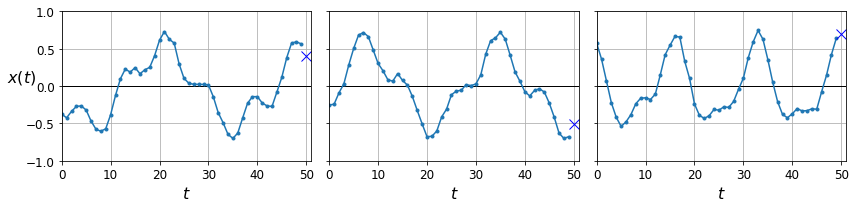

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 3))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just take the last observed value as the prediction):

In [0]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

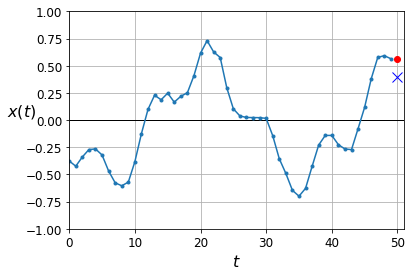

In [0]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

*Linear* predictions, training time: less than 1 min (note how no activation is specified):

![alt text](https://i.imgur.com/mfQMJAW.png)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)     # no activation function
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 167us/sample - loss: 0.1015 - val_loss: 0.0551
Epoch 2/20
7000/7000 [==============================] - 0s 57us/sample - loss: 0.0384 - val_loss: 0.0267
Epoch 3/20
7000/7000 [==============================] - 0s 58us/sample - loss: 0.0205 - val_loss: 0.0161
Epoch 4/20
7000/7000 [==============================] - 0s 58us/sample - loss: 0.0133 - val_loss: 0.0119
Epoch 5/20
7000/7000 [==============================] - 0s 58us/sample - loss: 0.0104 - val_loss: 0.0099
Epoch 6/20
7000/7000 [==============================] - 0s 58us/sample - loss: 0.0090 - val_loss: 0.0088
Epoch 7/20
7000/7000 [==============================] - 0s 56us/sample - loss: 0.0081 - val_loss: 0.0079
Epoch 8/20
7000/7000 [==============================] - 0s 57us/sample - loss: 0.0073 - val_loss: 0.0074
Epoch 9/20
7000/7000 [==============================] - 0s 58us/sample - loss: 0.0067 - val_loss: 0.0066
Epoch 

In [0]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 40us/sample - loss: 0.0042


0.004174047749489546

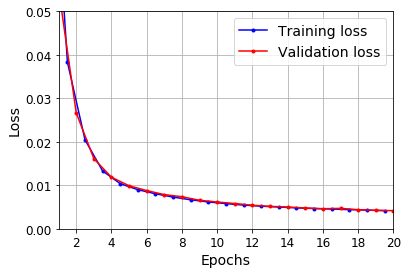

In [0]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

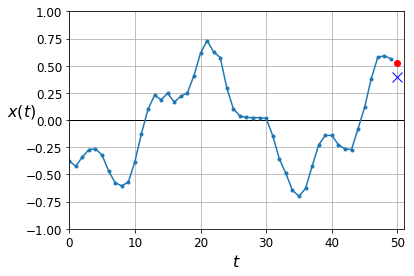

In [0]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

Simple RNN
![alt text](https://i.imgur.com/lTXIldL.png) (source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

(training time: 5 mins)
![alt text](https://i.imgur.com/iM8Dzrj.png)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]) # a recurrent neural network can process any number of time steps
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [0]:
# You could try to save the model after every epoch. (put this callback function into callbacks)
save_model_callback = keras.callbacks.ModelCheckpoint("weights.{epoch:02d}-{val_loss:.2f}.hdf5")

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[save_model_callback])

Train on 7000 samples, validate on 2000 samples
Epoch 1/10
7000/7000 [==============================] - 6s 921us/sample - loss: 0.0960 - val_loss: 0.0482
Epoch 2/10
7000/7000 [==============================] - 6s 840us/sample - loss: 0.0366 - val_loss: 0.0293
Epoch 3/10
7000/7000 [==============================] - 6s 844us/sample - loss: 0.0251 - val_loss: 0.0216
Epoch 4/10
7000/7000 [==============================] - 6s 877us/sample - loss: 0.0196 - val_loss: 0.0175
Epoch 5/10
7000/7000 [==============================] - 6s 877us/sample - loss: 0.0165 - val_loss: 0.0150
Epoch 6/10
7000/7000 [==============================] - 6s 847us/sample - loss: 0.0145 - val_loss: 0.0133
Epoch 7/10
7000/7000 [==============================] - 6s 861us/sample - loss: 0.0132 - val_loss: 0.0123
Epoch 8/10
7000/7000 [==============================] - 6s 852us/sample - loss: 0.0123 - val_loss: 0.0116
Epoch 9/10
7000/7000 [==============================] - 6s 844us/sample - loss: 0.0118 - val_loss: 0.011

In [0]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 356us/sample - loss: 0.0110


0.011008462056517601

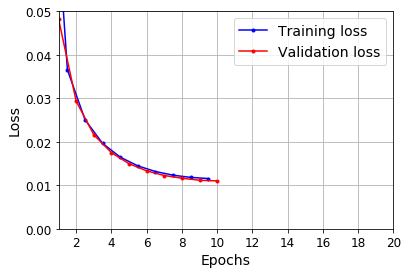

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

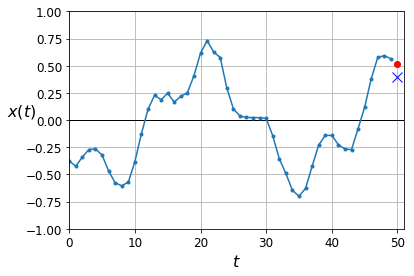

In [0]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

(training time: 20mins)

![alt text](https://i.imgur.com/pCmwDhG.png)
![alt text](https://i.imgur.com/G6ffsS0.png)

In [0]:
# simpleRNN api doc: https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN

np.random.seed(42)
tf.random.set_seed(42)

# return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/10
7000/7000 [==============================] - 36s 5ms/sample - loss: 0.0502 - val_loss: 0.0093
Epoch 2/10
7000/7000 [==============================] - 35s 5ms/sample - loss: 0.0069 - val_loss: 0.0055
Epoch 3/10
7000/7000 [==============================] - 35s 5ms/sample - loss: 0.0050 - val_loss: 0.0044
Epoch 4/10
7000/7000 [==============================] - 34s 5ms/sample - loss: 0.0048 - val_loss: 0.0040
Epoch 5/10
7000/7000 [==============================] - 35s 5ms/sample - loss: 0.0041 - val_loss: 0.0037
Epoch 6/10
3072/7000 [============>.................] - ETA: 18s - loss: 0.0043

In [0]:
model.evaluate(X_valid, y_valid)

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

(training time: 10~15 mins)
![alt text](https://i.imgur.com/Lm4VAOP.png)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

In [0]:
model.evaluate(X_valid, y_valid)

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

If you want to predict, say the output for the next 10 time steps, you can just feed the output of the back into the input as if it is the real input. (T: use whiteboard)

In [0]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)            # generate a time series for testing
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]   # X_new: 50 steps, Y_new: 10 steps
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [0]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


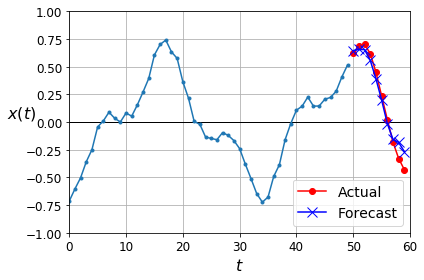

In [0]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

You can see that as the prediction moves further in the future, the results are worse.

Alternatively, we can create an RNN that predicts all 10 next values at once. You essentially change it into a **sequence to vector** network.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

![alt text](https://i.imgur.com/230OzFu.png)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)       # output all 10 next values at once
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/2
7000/7000 [==============================] - 33s 5ms/sample - loss: 0.0670 - val_loss: 0.0341
Epoch 2/2
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0267 - val_loss: 0.0195


In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

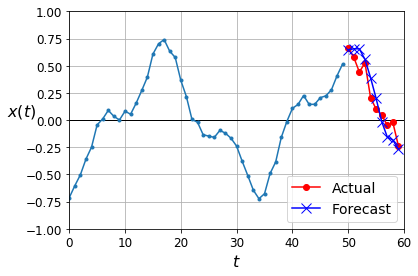

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. This makes your model a **sequence to sequence** network. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))

for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [0]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

(training time: 10~15 mins)
![alt text](https://i.imgur.com/6FjfRpr.png)

In [0]:
# tf.keras.layers.TimeDistributed api doc: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 33s 5ms/sample - loss: 0.0743 - last_time_step_mse: 0.0648 - val_loss: 0.0470 - val_last_time_step_mse: 0.0343
Epoch 2/5
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0440 - last_time_step_mse: 0.0310 - val_loss: 0.0412 - val_last_time_step_mse: 0.0267
Epoch 3/5
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0397 - last_time_step_mse: 0.0258 - val_loss: 0.0379 - val_last_time_step_mse: 0.0232
Epoch 4/5
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0373 - last_time_step_mse: 0.0225 - val_loss: 0.0361 - val_last_time_step_mse: 0.0214
Epoch 5/5
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0359 - last_time_step_mse: 0.0211 - val_loss: 0.0355 - val_last_time_step_mse: 0.0205


In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

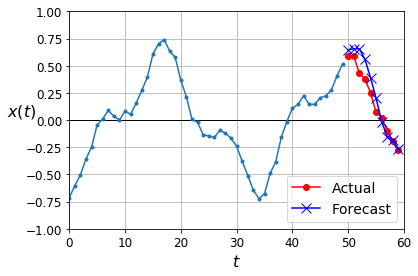

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [0]:
np.random.seed(44) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 20)            # generate a time series for testing
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]   # X_new: 50 steps, Y_new: 20 steps
X = X_new

# X: [batch size, steps, 1]
# predition: [batch_size, 10]
for step_ahead in range(2):
    y_pred_one = model.predict(X[:, step_ahead*10:])[:, -1][...,np.newaxis]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

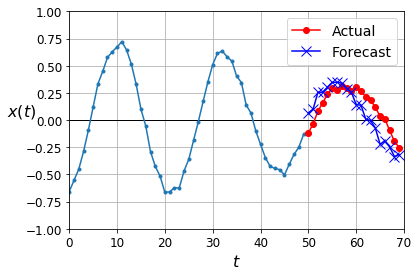

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN with Batch Norm

In [0]:
# In practice, Batch norm is detrimental to RNN

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 34s 5ms/sample - loss: 0.1939 - last_time_step_mse: 0.1922 - val_loss: 0.0876 - val_last_time_step_mse: 0.0834
Epoch 2/5
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0536 - last_time_step_mse: 0.0448 - val_loss: 0.0553 - val_last_time_step_mse: 0.0467
Epoch 3/5
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0472 - last_time_step_mse: 0.0377 - val_loss: 0.0450 - val_last_time_step_mse: 0.0353
Epoch 4/5
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0438 - last_time_step_mse: 0.0338 - val_loss: 0.0423 - val_last_time_step_mse: 0.0331
Epoch 5/5
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0408 - last_time_step_mse: 0.0304 - val_loss: 0.0394 - val_last_time_step_mse: 0.0285


# Deep RNNs with Layer Norm

In [0]:
from tensorflow.keras.layers import LayerNormalization

In [0]:
# subclassing tutorial: https://www.tensorflow.org/beta/guide/keras/custom_layers_and_models

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
        
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/2
7000/7000 [==============================] - 67s 10ms/sample - loss: 0.1645 - last_time_step_mse: 0.1595 - val_loss: 0.0740 - val_last_time_step_mse: 0.0700
Epoch 2/2
7000/7000 [==============================] - 65s 9ms/sample - loss: 0.0646 - last_time_step_mse: 0.0565 - val_loss: 0.0592 - val_last_time_step_mse: 0.0500


# LSTMs

(training time: 2~3 mins)
![alt text](https://i.imgur.com/cVbrrOK.png)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0759 - last_time_step_mse: 0.0615 - val_loss: 0.0551 - val_last_time_step_mse: 0.0364
Epoch 2/5
7000/7000 [==============================] - 5s 755us/sample - loss: 0.0477 - last_time_step_mse: 0.0275 - val_loss: 0.0421 - val_last_time_step_mse: 0.0211
Epoch 3/5
7000/7000 [==============================] - 5s 746us/sample - loss: 0.0390 - last_time_step_mse: 0.0183 - val_loss: 0.0364 - val_last_time_step_mse: 0.0151
Epoch 4/5
7000/7000 [==============================] - 5s 751us/sample - loss: 0.0351 - last_time_step_mse: 0.0152 - val_loss: 0.0336 - val_last_time_step_mse: 0.0132
Epoch 5/5
7000/7000 [==============================] - 5s 748us/sample - loss: 0.0327 - last_time_step_mse: 0.0135 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121


In [0]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 237us/sample - loss: 0.0314 - last_time_step_mse: 0.0121


[0.03144018071889877, 0.01211183]

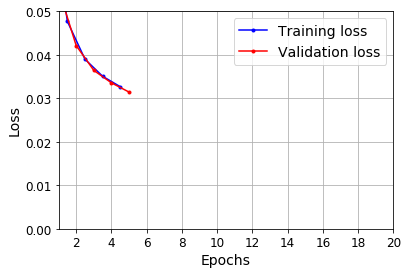

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

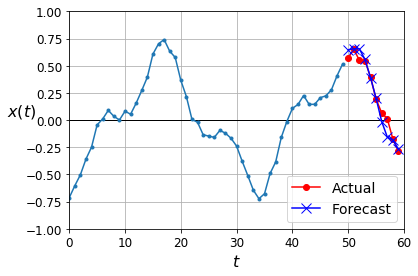

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

(training time: 1~2 mins)
![alt text](https://i.imgur.com/MplugMd.png)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0742 - last_time_step_mse: 0.0667 - val_loss: 0.0528 - val_last_time_step_mse: 0.0414
Epoch 2/20
7000/7000 [==============================] - 5s 761us/sample - loss: 0.0476 - last_time_step_mse: 0.0365 - val_loss: 0.0440 - val_last_time_step_mse: 0.0326
Epoch 3/20
7000/7000 [==============================] - 5s 765us/sample - loss: 0.0418 - last_time_step_mse: 0.0303 - val_loss: 0.0394 - val_last_time_step_mse: 0.0271
Epoch 4/20
7000/7000 [==============================] - 5s 773us/sample - loss: 0.0373 - last_time_step_mse: 0.0249 - val_loss: 0.0359 - val_last_time_step_mse: 0.0226
Epoch 5/20
7000/7000 [==============================] - 5s 767us/sample - loss: 0.0328 - last_time_step_mse: 0.0181 - val_loss: 0.0316 - val_last_time_step_mse: 0.0168
Epoch 6/20
7000/7000 [==============================] - 5s 774us/sample - loss: 0.0308 - last_time_step_mse: 0.015

In [0]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 238us/sample - loss: 0.0246 - last_time_step_mse: 0.0111


[0.024557730928063393, 0.011060882]

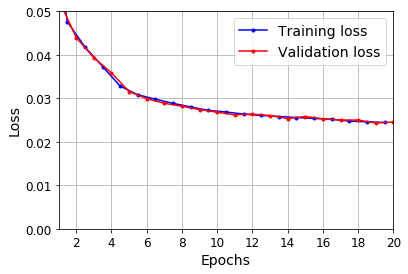

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

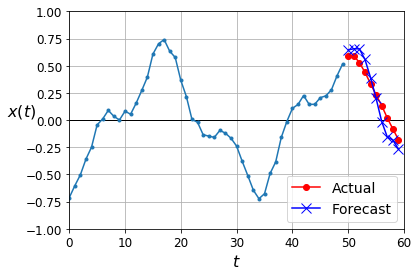

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# skip the first 3 timesteps in the targets and downsample the targets by a factor of 2
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 913us/sample - loss: 0.0681 - last_time_step_mse: 0.0608 - val_loss: 0.0477 - val_last_time_step_mse: 0.0397
Epoch 2/20
7000/7000 [==============================] - 3s 490us/sample - loss: 0.0411 - last_time_step_mse: 0.0338 - val_loss: 0.0367 - val_last_time_step_mse: 0.0287
Epoch 3/20
7000/7000 [==============================] - 3s 487us/sample - loss: 0.0339 - last_time_step_mse: 0.0259 - val_loss: 0.0310 - val_last_time_step_mse: 0.0217
Epoch 4/20
7000/7000 [==============================] - 3s 490us/sample - loss: 0.0284 - last_time_step_mse: 0.0186 - val_loss: 0.0260 - val_last_time_step_mse: 0.0151
Epoch 5/20
7000/7000 [==============================] - 3s 484us/sample - loss: 0.0248 - last_time_step_mse: 0.0140 - val_loss: 0.0243 - val_last_time_step_mse: 0.0137
Epoch 6/20
7000/7000 [==============================] - 3s 482us/sample - loss: 0.0234 - last_time_step_mse: 0.0

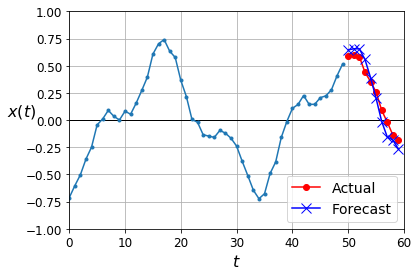

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## WaveNet

![alt text](https://cdn-images-1.medium.com/max/1400/1*0TbaaX8l86ghbGEhuSjPzw.jpeg)

Please check this gif: https://deepmind.com/blog/wavenet-generative-model-raw-audio/#gif-7

In [0]:
# dilated convolution: https://arxiv.org/pdf/1511.07122.pdf

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, None, 20)          60        
_________________________________________________________________
conv1d_28 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_29 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_32 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_33 (Conv1D)           (None, None, 20)        

In [0]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 592us/sample - loss: 0.0669 - last_time_step_mse: 0.0547 - val_loss: 0.0372 - val_last_time_step_mse: 0.0244
Epoch 2/20
7000/7000 [==============================] - 2s 324us/sample - loss: 0.0326 - last_time_step_mse: 0.0203 - val_loss: 0.0296 - val_last_time_step_mse: 0.0174
Epoch 3/20
7000/7000 [==============================] - 2s 340us/sample - loss: 0.0285 - last_time_step_mse: 0.0170 - val_loss: 0.0270 - val_last_time_step_mse: 0.0155
Epoch 4/20
7000/7000 [==============================] - 2s 338us/sample - loss: 0.0266 - last_time_step_mse: 0.0152 - val_loss: 0.0261 - val_last_time_step_mse: 0.0144
Epoch 5/20
7000/7000 [==============================] - 2s 338us/sample - loss: 0.0253 - last_time_step_mse: 0.0138 - val_loss: 0.0245 - val_last_time_step_mse: 0.0129
Epoch 6/20
7000/7000 [==============================] - 2s 338us/sample - loss: 0.0245 - last_time_step_mse: 0.0

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

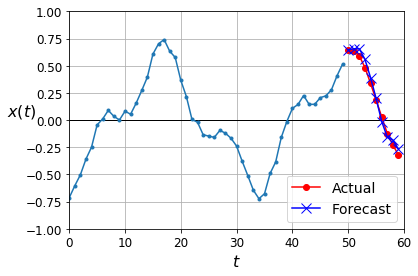

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Exercise

In [0]:
def generate_cos_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)                             # Return evenly spaced numbers over a specified interval
    series = 0.5 * np.cos((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.cos((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_cos_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))

for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [0]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

''' 
TODO
1. Construct the network.
2. Define the loss function and optimizer
3. train the model
'''

model = keras.models.Sequential([
   '''
   Define your network here
   '''
])

'''
Define the loss the optimizer
'''
model.compile(loss=???, optimizer=???, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=???, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0754 - last_time_step_mse: 0.0617 - val_loss: 0.0544 - val_last_time_step_mse: 0.0361
Epoch 2/20
7000/7000 [==============================] - 5s 764us/sample - loss: 0.0462 - last_time_step_mse: 0.0263 - val_loss: 0.0409 - val_last_time_step_mse: 0.0200
Epoch 3/20
7000/7000 [==============================] - 5s 766us/sample - loss: 0.0378 - last_time_step_mse: 0.0177 - val_loss: 0.0359 - val_last_time_step_mse: 0.0164
Epoch 4/20
7000/7000 [==============================] - 5s 763us/sample - loss: 0.0344 - last_time_step_mse: 0.0154 - val_loss: 0.0329 - val_last_time_step_mse: 0.0136
Epoch 5/20
7000/7000 [==============================] - 5s 771us/sample - loss: 0.0321 - last_time_step_mse: 0.0139 - val_loss: 0.0309 - val_last_time_step_mse: 0.0127
Epoch 6/20
7000/7000 [==============================] - 5s 766us/sample - loss: 0.0304 - last_time_step_mse: 0.012

In [0]:
np.random.seed(50) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 20)            # generate a time series for testing
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]   # X_new: 50 steps, Y_new: 20 steps
X = X_new

for step_ahead in range(2):
    y_pred_one = model.predict(X[:, step_ahead*10:])[:, -1][...,np.newaxis]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

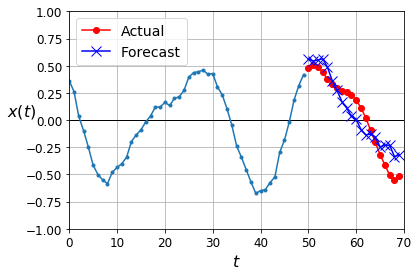

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()